In [1]:
% matplotlib inline

# Scoring

## Load data

In [2]:
import glob
import os
from dataset import Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import seaborn as sns

LABELS = {True, False}


def get_labels(text_to_label):
    return list(i[1] for i in sorted(text_to_label))

gold_dev = Dataset.from_csv('../shared-task/dev.csv')
if os.path.exists('../shared-task/test.csv'):
    gold_test = Dataset.from_csv('../shared-task/test.csv')
else:
    gold_test = None

    
submissions = []
datasets = {}
for sub_dir in glob.glob('../submissions/*'):
    data = {
        'username': os.path.basename(sub_dir),
    }
    print('Reading {}'.format(sub_dir))
    path = os.path.join(sub_dir, 'train.csv')
    if os.path.exists(path):
        train = Dataset.from_csv(path)
        data['train_n'] = len(train)
        for label, count in train.label_distribution.items():
            if label not in LABELS:
                print('\tSkipping label {} (count={})'.format(label, count))
            else:
                data['train_{}'.format(label)] = count
    for fname, gold in [('dev.csv', gold_dev), ('test.csv', gold_test)]:
        # Prepare gold text and labels.
        gold_text = set(i[0] for i in gold.oracle_items)
        gold_labels = get_labels(gold.oracle_items)
        
        # Load system data.
        split = fname.split('.')[0]
        path = os.path.join(sub_dir, fname)
        if os.path.exists(path):
            system = Dataset.from_csv(path)
        else:
            system = None
        
        if not system or not gold:
            print('\tSkipping {}'.format(split))
            continue
        else:
            print('\tEvaluating {}\t{}\t{}'.format(split, len(gold), len(system)))
        
        # Check the data is the same set.
        system_text = set(i[0] for i in system.oracle_items)
        assert system_text == gold_text
        system_labels = get_labels(system.oracle_items)
        if not set(system_labels).issubset(LABELS):
            print('\tSkipping incomplete system labels {}'.format(set(system_labels)))
            continue
        if not set(gold_labels).issubset(LABELS):
            print('\tSkipping incomplete gold labels {}'.format(set(gold_labels)))
            continue
        
        # Calculate and add metrics.
        p, r, f, s = precision_recall_fscore_support(
            gold_labels,
            system_labels,
        )
        for key, (value_false, value_true) in zip('prf', (p, r, f)):
            data['{}_{}_{}'.format(split, key, False)] = value_false
            data['{}_{}_{}'.format(split, key, True)] = value_true
        p, r, f, s = precision_recall_fscore_support(
            gold_labels,
            system_labels,
            average='micro',
        )
        for key, value in zip('prf', (p, r, f)):
            data['{}_{}_micro'.format(split, key)] = value
        datasets.setdefault(split, {})[data['username']] = system
    submissions.append(data)
        
cols = [
  'dev_p_False',
  'dev_r_False',
  'dev_f_False',
  'dev_p_True',
  'dev_r_True',
  'dev_f_True',
  'dev_p_micro',
  'dev_r_micro',
  'dev_f_micro',
]
cols.extend([l.replace('dev_', 'test_') for l in cols])

df = pd.DataFrame(submissions,
                  columns=[
                      'username',
                      'train_n',
                      'train_True',
                      'train_False',
                  ] + cols)
df = df.fillna(0)

Reading ../submissions/benhachey
	Skipping label None (count=44)
	Evaluating dev	3761	3761
	Evaluating test	3761	3761
Reading ../submissions/wradford
	Skipping label None (count=30)
	Evaluating dev	3761	3761
	Evaluating test	3761	3761


## Submissions ordered by micro-averaged F1 on dev

In [3]:
df.sort_values('dev_f_micro', ascending=False)[['username', 'dev_p_micro', 
                                                'dev_r_micro', 'dev_f_micro']]

,username,dev_p_micro,dev_r_micro,dev_f_micro
0,benhachey,0.643446,0.643446,0.643446
1,wradford,0.537091,0.537091,0.537091


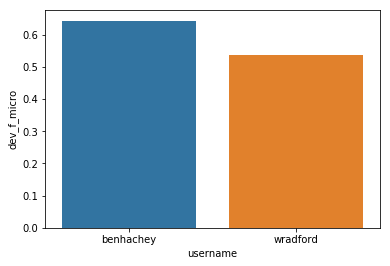

In [4]:
sns.barplot(x='username', y='dev_f_micro', data=df)

## Submissions ordered by micro-averaged F1 on test

In [5]:
df.sort_values('test_f_micro', ascending=False)[['username', 'test_p_micro', 
                                                'test_r_micro', 'test_f_micro']]

,username,test_p_micro,test_r_micro,test_f_micro
1,wradford,0.643446,0.643446,0.643446
0,benhachey,0.537091,0.537091,0.537091


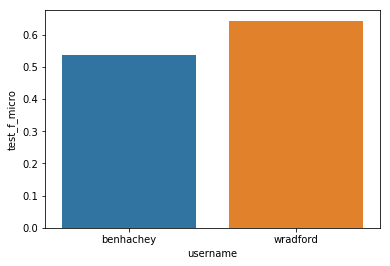

In [6]:
sns.barplot(x='username', y='test_f_micro', data=df)

## Pairwise accuracy

In [7]:
import itertools

def plot_pairwise(datasets, split='dev'):
    users = list(sorted(datasets[split].keys()))

    pairs = {}
    for i in users:
        pairs[i] = {j: 0 for j in users}

    for i, j in itertools.combinations(users, 2):
        print(i, j)
        a = accuracy_score(
            get_labels(datasets[split][i].oracle_items),
            get_labels(datasets[split][j].oracle_items),
        )
        pairs[i][j] = a
        pairs[j][i] = a

    flat = []
    for i, j_a in pairs.items():
        for j, a in j_a.items():
            flat.append({
                'i': i,
                'j': j,
                'a': a,
            })

    sns.heatmap(pd.DataFrame(flat).pivot('i', 'j', 'a'),
                annot=True,
                linewidths=1,
                square=True,
                cmap=sns.color_palette("BuGn_r"))

benhachey wradford


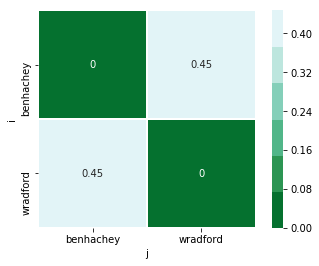

In [8]:
plot_pairwise(datasets, 'dev')

benhachey wradford


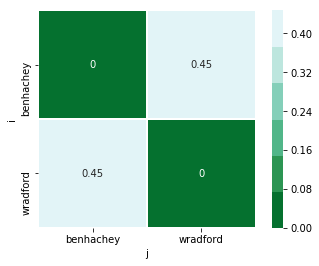

In [9]:
plot_pairwise(datasets, 'test')